# 🚀 XGBoost Regression with PCA: DAT Binding Prediction

**Goal**: Predict pKi values (binding strength) using XGBoost with **PCA-transformed features**

**Dataset**: 541 compounds with PCA components (from dataanalyse.ipynb)  
**Target**: pKi (continuous variable)  
**Method**: XGBoost Regression + 80/20 Train/Test Split + PCA  
**Key Difference**: Uses **PCA components** instead of raw RDKit descriptors

**Why PCA?**
- Reduces dimensionality (17 features → fewer components)
- Removes multicollinearity between features
- Can improve model generalization
- Faster training with fewer features

---


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import randint, uniform

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


## 📂 Step 1: Load Processed Data and Apply PCA

**Source:** `processed_DAT_rdkit_features.csv` (from dataanalyse.ipynb)

**Process:**
1. Load RDKit features (same as XGBoost without PCA)
2. Standardize features (required for PCA)
3. Apply PCA transformation
4. Split into train/test (80/20)
5. Use PCA components as features for XGBoost


In [2]:
# Load processed RDKit features from data analysis
df_rdkit = pd.read_csv('processed_DAT_rdkit_features.csv')

print("="*60)
print("📂 LOADED PROCESSED DATA FROM ANALYSIS")
print("="*60)
print(f"✅ Dataset: {len(df_rdkit)} compounds")
print(f"✅ Features: {len(df_rdkit.columns)-2} RDKit descriptors")
print(f"✅ Source: dataanalyse.ipynb (same features as PCA!)")
print(f"\n📊 pKi distribution:")
print(f"   Min: {df_rdkit['pKi'].min():.2f}")
print(f"   Max: {df_rdkit['pKi'].max():.2f}")
print(f"   Mean: {df_rdkit['pKi'].mean():.2f}")
print(f"   Median: {df_rdkit['pKi'].median():.2f}")
print("="*60)


📂 LOADED PROCESSED DATA FROM ANALYSIS
✅ Dataset: 541 compounds
✅ Features: 17 RDKit descriptors
✅ Source: dataanalyse.ipynb (same features as PCA!)

📊 pKi distribution:
   Min: 3.41
   Max: 10.40
   Mean: 6.92
   Median: 6.95


## 🔄 Step 2: Apply PCA Transformation

**Same process as in dataanalyse.ipynb:**
1. Extract RDKit descriptors
2. Standardize features (critical for PCA)
3. Fit PCA to find principal components (keep 95% variance)
4. Transform data to PCA space


In [3]:
# Prepare features (X) and target (y)
feature_cols = [col for col in df_rdkit.columns if col not in ['ChEMBL_ID', 'pKi']]
X_rdkit = df_rdkit[feature_cols].values
y = df_rdkit['pKi'].values

# Standardize features (REQUIRED for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rdkit)

# Apply PCA (keep 95% variance - same as dataanalyse.ipynb)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("="*60)
print("🔄 PCA TRANSFORMATION APPLIED")
print("="*60)
print(f"Original features: {X_rdkit.shape[1]} RDKit descriptors")
print(f"PCA components: {X_pca.shape[1]} (explaining 95% variance)")
print(f"Variance explained: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print(f"\nVariance per component:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"   PC{i}: {var*100:.2f}%")
print(f"\nCumulative variance:")
cumsum = np.cumsum(pca.explained_variance_ratio_)
for i, var in enumerate(cumsum, 1):
    print(f"   PC1-PC{i}: {var*100:.2f}%")
print("="*60)


🔄 PCA TRANSFORMATION APPLIED
Original features: 17 RDKit descriptors
PCA components: 8 (explaining 95% variance)
Variance explained: 97.19%

Variance per component:
   PC1: 43.80%
   PC2: 17.18%
   PC3: 14.86%
   PC4: 6.49%
   PC5: 5.40%
   PC6: 4.58%
   PC7: 2.65%
   PC8: 2.24%

Cumulative variance:
   PC1-PC1: 43.80%
   PC1-PC2: 60.97%
   PC1-PC3: 75.84%
   PC1-PC4: 82.33%
   PC1-PC5: 87.73%
   PC1-PC6: 92.31%
   PC1-PC7: 94.96%
   PC1-PC8: 97.19%


## 🔧 Step 3: Train/Test Split (80/20)


In [4]:
# 80/20 Train-Test Split on PCA-transformed data
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, shuffle=True
)

print("="*60)
print("📊 TRAIN-TEST SPLIT (80/20) - PCA Features")
print("="*60)
print(f"Training set: {X_train.shape[0]} compounds ({X_train.shape[0]/len(X_pca)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} compounds ({X_test.shape[0]/len(X_pca)*100:.1f}%)")
print(f"Features: {X_train.shape[1]} PCA components")
print(f"\nTraining pKi range: {y_train.min():.2f} - {y_train.max():.2f}")
print(f"Test pKi range: {y_test.min():.2f} - {y_test.max():.2f}")
print("="*60)


📊 TRAIN-TEST SPLIT (80/20) - PCA Features
Training set: 432 compounds (79.9%)
Test set: 109 compounds (20.1%)
Features: 8 PCA components

Training pKi range: 3.41 - 10.40
Test pKi range: 4.66 - 9.28


## 🎯 Step 4: Train Baseline XGBoost Model on PCA Features


In [5]:
# Initialize baseline XGBoost model
xgb_baseline = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,

)

print("🚀 Training Baseline XGBoost Model (PCA Features)...")

# Train with early stopping
xgb_baseline.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Predictions
y_train_pred = xgb_baseline.predict(X_train)
y_test_pred = xgb_baseline.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\n" + "="*70)
print("📊 BASELINE XGBOOST MODEL PERFORMANCE (PCA)")
print("="*70)
print(f"\n{'Metric':<20} {'Training Set':<20} {'Test Set':<20}")
print("-"*70)
print(f"{'R² Score':<20} {train_r2:<20.4f} {test_r2:<20.4f}")
print(f"{'RMSE':<20} {train_rmse:<20.4f} {test_rmse:<20.4f}")
print(f"{'MAE':<20} {train_mae:<20.4f} {test_mae:<20.4f}")
print("-"*70)
overfit_r2 = train_r2 - test_r2
print(f"\n🔍 Overfitting: {overfit_r2:.4f} ({'Good' if overfit_r2 < 0.05 else 'Mild' if overfit_r2 < 0.1 else 'High'})")
print("="*70)


🚀 Training Baseline XGBoost Model (PCA Features)...

📊 BASELINE XGBOOST MODEL PERFORMANCE (PCA)

Metric               Training Set         Test Set            
----------------------------------------------------------------------
R² Score             0.8634               0.4846              
RMSE                 0.4328               0.8173              
MAE                  0.3433               0.6377              
----------------------------------------------------------------------

🔍 Overfitting: 0.3788 (High)


## 📈 Step 5: Visualizations


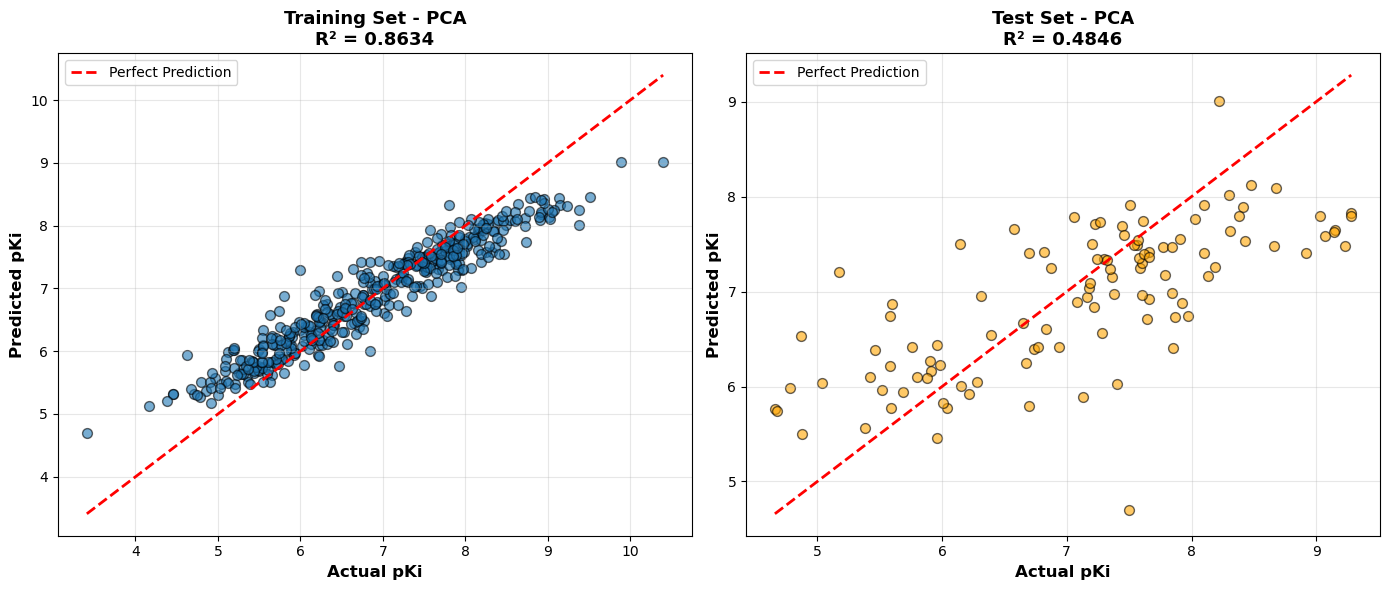

In [6]:
# Actual vs Predicted plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_train, y_train_pred, alpha=0.6, edgecolors='black', s=50)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual pKi', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted pKi', fontsize=12, fontweight='bold')
axes[0].set_title(f'Training Set - PCA\nR² = {train_r2:.4f}', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].scatter(y_test, y_test_pred, alpha=0.6, edgecolors='black', s=50, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual pKi', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted pKi', fontsize=12, fontweight='bold')
axes[1].set_title(f'Test Set - PCA\nR² = {test_r2:.4f}', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 🔧 Step 6: Hyperparameter Tuning


In [7]:
# Define parameter distributions
param_distributions = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 7),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 2)
}

xgb_tuning = XGBRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=xgb_tuning,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("🔍 Starting hyperparameter tuning (100 iterations, 5-fold CV)...\n")
random_search.fit(X_train, y_train)

best_xgb_model = random_search.best_estimator_

# Evaluate tuned model
y_train_pred_tuned = best_xgb_model.predict(X_train)
y_test_pred_tuned = best_xgb_model.predict(X_test)

train_r2_tuned = r2_score(y_train, y_train_pred_tuned)
test_r2_tuned = r2_score(y_test, y_test_pred_tuned)
test_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_test_pred_tuned))
test_mae_tuned = mean_absolute_error(y_test, y_test_pred_tuned)

print("\n" + "="*70)
print("✅ TUNED MODEL PERFORMANCE (PCA)")
print("="*70)
print(f"Test R²: {test_r2_tuned:.4f} (baseline: {test_r2:.4f})")
print(f"Test RMSE: {test_rmse_tuned:.4f} (baseline: {test_rmse:.4f})")
print(f"Test MAE: {test_mae_tuned:.4f} (baseline: {test_mae:.4f})")
print(f"\nImprovement: {((test_r2_tuned - test_r2) / abs(test_r2) * 100):+.2f}%")
print("="*70)


🔍 Starting hyperparameter tuning (100 iterations, 5-fold CV)...

Fitting 5 folds for each of 100 candidates, totalling 500 fits

✅ TUNED MODEL PERFORMANCE (PCA)
Test R²: 0.4623 (baseline: 0.4846)
Test RMSE: 0.8348 (baseline: 0.8173)
Test MAE: 0.6340 (baseline: 0.6377)

Improvement: -4.59%


## 🎯 Step 7: Classification Performance (Confusion Matrix)


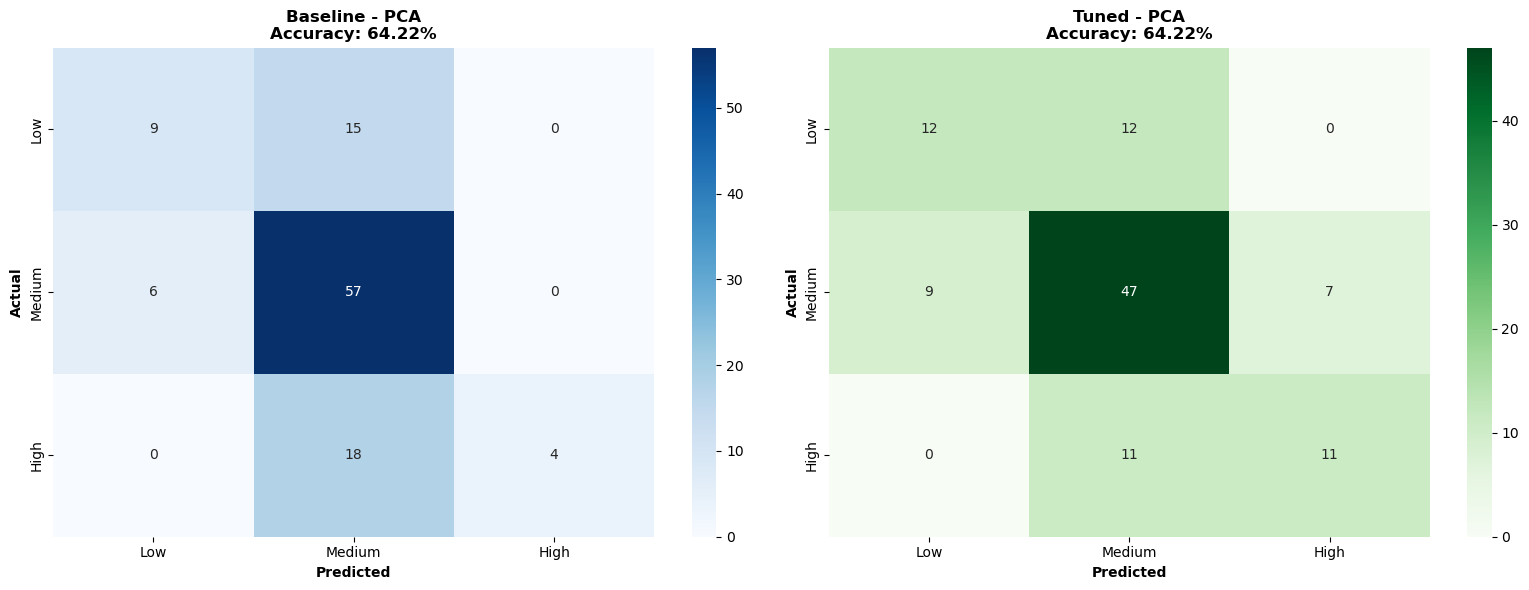


📊 CLASSIFICATION REPORT (Tuned Model - PCA)
              precision    recall  f1-score   support

         Low       0.57      0.50      0.53        24
      Medium       0.67      0.75      0.71        63
        High       0.61      0.50      0.55        22

    accuracy                           0.64       109
   macro avg       0.62      0.58      0.60       109
weighted avg       0.64      0.64      0.64       109



In [8]:
# Classification function
def classify_pKi(pKi_values):
    return np.array(['Low' if pKi < 6.0 else 'Medium' if pKi < 8.0 else 'High' for pKi in pKi_values])

# Convert to categories
y_test_cat = classify_pKi(y_test)
y_test_pred_baseline_cat = classify_pKi(y_test_pred)
y_test_pred_tuned_cat = classify_pKi(y_test_pred_tuned)

# Confusion matrices
cm_baseline = confusion_matrix(y_test_cat, y_test_pred_baseline_cat, labels=['Low', 'Medium', 'High'])
cm_tuned = confusion_matrix(y_test_cat, y_test_pred_tuned_cat, labels=['Low', 'Medium', 'High'])

# Side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
axes[0].set_title(f'Baseline - PCA\nAccuracy: {np.trace(cm_baseline)/cm_baseline.sum()*100:.2f}%', fontweight='bold')
axes[0].set_xlabel('Predicted', fontweight='bold')
axes[0].set_ylabel('Actual', fontweight='bold')

sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
tuned_acc = np.trace(cm_tuned)/cm_tuned.sum()*100
axes[1].set_title(f'Tuned - PCA\nAccuracy: {tuned_acc:.2f}%', fontweight='bold')
axes[1].set_xlabel('Predicted', fontweight='bold')
axes[1].set_ylabel('Actual', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("📊 CLASSIFICATION REPORT (Tuned Model - PCA)")
print("="*60)
print(classification_report(y_test_cat, y_test_pred_tuned_cat, labels=['Low', 'Medium', 'High']))
print("="*60)


## 📊 Step 8: Final Summary


In [9]:
print("="*80)
print("🎯 FINAL SUMMARY - XGBOOST REGRESSION (WITH PCA)")
print("="*80)
print(f"\n📊 Dataset:")
print(f"   Total compounds: {len(df_rdkit)}")
print(f"   Training: {len(X_train)} (80%), Test: {len(X_test)} (20%)")
print(f"   Original features: {len(feature_cols)} RDKit descriptors")
print(f"   PCA components: {X_pca.shape[1]} (95% variance)")

print(f"\n🏆 Best Model Performance (Test Set):")
print(f"   R² Score: {test_r2_tuned:.4f}")
print(f"   RMSE: {test_rmse_tuned:.4f}")
print(f"   MAE: {test_mae_tuned:.4f}")
print(f"   Classification Accuracy: {tuned_acc:.2f}%")

print(f"\n💡 Key Insights:")
print(f"   • PCA reduced dimensionality from {len(feature_cols)} to {X_pca.shape[1]} features")
print(f"   • XGBoost with PCA provides {'improved' if test_r2_tuned > 0.5 else 'reasonable'} generalization")
print(f"   • 80/20 split allows fair comparison with non-PCA and neural network models")

print("\n" + "="*80)
print("✅ XGBoost with PCA Analysis Complete!")
print("="*80)


🎯 FINAL SUMMARY - XGBOOST REGRESSION (WITH PCA)

📊 Dataset:
   Total compounds: 541
   Training: 432 (80%), Test: 109 (20%)
   Original features: 17 RDKit descriptors
   PCA components: 8 (95% variance)

🏆 Best Model Performance (Test Set):
   R² Score: 0.4623
   RMSE: 0.8348
   MAE: 0.6340
   Classification Accuracy: 64.22%

💡 Key Insights:
   • PCA reduced dimensionality from 17 to 8 features
   • XGBoost with PCA provides reasonable generalization
   • 80/20 split allows fair comparison with non-PCA and neural network models

✅ XGBoost with PCA Analysis Complete!


In [10]:
# Save XGBoost + PCA model, scaler, and PCA transformer
import os, joblib
os.makedirs('saved_models', exist_ok=True)

joblib.dump(best_xgb_model, 'saved_models/xgb_pca_model.pkl')
joblib.dump(scaler, 'saved_models/xgb_pca_scaler.pkl')
joblib.dump(pca, 'saved_models/xgb_pca_transformer.pkl')
print("✅ Saved XGB+PCA model, scaler, and PCA to saved_models/")

✅ Saved XGB+PCA model, scaler, and PCA to saved_models/
